### Importa los módulos necesarios

In [1]:
import random
import math
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from paretoset import paretoset
from tqdm.notebook import trange, tqdm

%matplotlib inline

import matplotlib.pyplot as plt

### Lee los datos del problema

In [2]:
class Cliente:
    def __init__(self, numero, x, y, demanda, inicio, fin, tiempo):
        self.numero = int(float(numero))
        self.x = float(x)
        self.y = float(y)
        self.demanda = float(demanda)
        self.inicio = float(inicio)
        self.fin = float(fin)
        self.tiempo = float(tiempo)

    @property
    def coords(self):
        return np.array([self.x, self.y])

In [3]:
# Preprocesar los datos de entrada
def procesar_instancia(filename):
    with open(filename, "r") as f:
        lineas = f.readlines()

    # Obtener clientes y capacidad
    clientes = int(lineas[1])
    capacidad = int(lineas[3])

    # Obtener por cada cliente los datos
    lista = []
    for cliente in lineas[5:]:
        lista.append(Cliente(*cliente.strip().split()))

    return {'capacidad': capacidad, 'clientes': lista, 'num': len(lista)}

def hallar_tiempo(i: int, j: int, clientes: [Cliente]):
    return np.linalg.norm(clientes[i].coords - clientes[j].coords)

### Implementación del algoritmo M3AS

In [ ]:
class Solucion:
    def __init__(self, instancia):
        self.visitados = np.zeros(instancia['num'], dtype=np.bool8)
        self.visitados[0] = True
        self.caminos = [[]]
        self.tiempo_actual = 0
        self.consumo_capacidad = 0
        
        self.capacidad = instancia['capacidad']
        self.clientes = instancia['clientes']

    @property
    def num_vehiculos(self):
        return len(self.caminos)

    @property
    def nodo_actual(self):
        if len(self.caminos[-1]) > 0:
            _ , actual = self.caminos[-1][-1]
        else:
            actual = 0
        return actual

    def camino_en_vehiculo(self, i):
        return self.caminos[i]

    @property
    def completo(self):
        return False not in self.visitados

    @property
    def siguientes_nodos(self):
        i = self.nodo_actual
        no_visitados = np.where(self.visitados == False)[0]
        siguientes_j = []

        for j in no_visitados:
            # Verificar que cumpla la ventana
            tiempo = hallar_tiempo(i, j, self.clientes)
            tiempo_al_llegar = max(self.tiempo_actual + tiempo, self.clientes[j].inicio)
            
            if tiempo_al_llegar + self.clientes[j].tiempo > self.clientes[j].fin:
                continue # No va a poder atenderle antes del cierre
            
            # Verificar que cumpla la capacidad del vehiculo
            if self.consumo_capacidad + self.clientes[j].demanda > self.capacidad:
                continue # Supera la capacidad

            # Se puede visitar
            siguientes_j.append(j)

        return siguientes_j

    def agregar_camino(self, j):
        # El sumamos al tiempo lo que cuesta llegar hasta j y su servicio (se incluye la espera si llega antes)
        self.tiempo_actual = max(hallar_tiempo(self.nodo_actual, j, self.clientes) + 
                                 self.tiempo_actual, self.clientes[j].inicio) + self.clientes[j].tiempo
        self.visitados[j] = True
        self.consumo_capacidad = self.consumo_capacidad + self.clientes[j].demanda
        camino = (self.nodo_actual, j)
        self.caminos[-1].append( camino )

    def agregar_vehiculo(self):
        self.caminos.append([])
        self.tiempo_actual = 0
        self.consumo_capacidad = 0

    @property
    def tiempo_total(self):
        """
        Evalua el tiempo recorrido sin tener en cuenta el tiempo esperado
        """
        tiempo = 0.0
        for vehiculo in self.caminos:
            for viaje in vehiculo:
                tiempo = tiempo + hallar_tiempo(*viaje, self.clientes)

        return tiempo

In [ ]:
# Calcular Función Objetivo delta t
def feromona_a_depositar(solucion: Solucion, norm_vehiculo, norm_tiempo):
    return 1 / (solucion.num_vehiculos / norm_vehiculo + solucion.tiempo_total / norm_tiempo)


def t_max_calculado(feromona: float, p: float):
    return feromona / (1 - p)


def t_min_calculado(t_max: float, m: int):
    return t_max / 2 / m


def feromona_calculada(i, j, tabla_t, tabla_n_2, beta):
    visibilidades = tabla_n_2[i, j] 
    return tabla_t[i,j] * (visibilidades ** beta )


def probabilidades_transicion(i: int, nodos: [int], tabla_t, tabla_n_2, beta: float):
    probabilidades = np.array([ feromona_calculada(i,j, tabla_t, tabla_n_2, beta) for j in nodos ])
    total_probabilidades = probabilidades.sum()
    return probabilidades / total_probabilidades


def seleccionar_siguiente_estado(solucion: Solucion, tabla_t, tabla_n_2, beta: float):
    # Seleccionar siguiente nodo con distribución de probabilidad
    nodos_factibles = solucion.siguientes_nodos

    if len(nodos_factibles) > 0: # Hay nodos
        return np.random.choice(nodos_factibles, p=probabilidades_transicion(
            solucion.nodo_actual, nodos_factibles, tabla_t, tabla_n_2, beta))
    else:
        # Ya es muy tarde o ya atendió su capacidad máxima
        return 0 # Volvemos al deposito


def construir_solucion(instancia: dict, tabla_t, tabla_n_2, beta: float) -> Solucion:
    solucion = Solucion(instancia)
    while not solucion.completo: # While existen estados no visitados
        siguiente = seleccionar_siguiente_estado(solucion, tabla_t, tabla_n_2, beta)
        solucion.agregar_camino(siguiente)

        if siguiente == 0:
            # No hay más nodos siguientes, se debe usar otro auto
            solucion.agregar_vehiculo()

    solucion.agregar_camino(0) # Volver al deposito
    return solucion


def m3as(instancia, m=100, p=0.7, beta=0.7):

    n = instancia['num']
    tabla_t = np.full((n, n), 1.0) # T_i,j
    tabla_n_2 = np.empty((n, n)) # N_i,j

    # Inicializar visibilidad de tiempo
    for i in range(n):
        for j in range(n):
            tabla_n_2[i,j] = 1.0 / hallar_tiempo(i,j, instancia['clientes']) \
                             if hallar_tiempo(i,j, instancia['clientes']) > 0 \
                             else 1
    
    pareto_set: [Solucion] = []
    pareto_generacion: [Solucion] = []
    
    for generacion in trange(10, desc="Generación"): # While not condición de parada
        for _ in trange(m, desc="Hormiga", leave=False): # Por cada hormiga
            # Construir solución y evaluar
            solucion = construir_solucion(instancia, tabla_t, tabla_n_2, beta)

            # Actaulizar pareto si es que domina
            pareto_generacion.append(solucion)
            pareto_set.append(solucion)
            objective_values_array = np.vstack([
                [s.num_vehiculos, s.tiempo_total] for s in pareto_set
            ])
            mask = paretoset(objective_values_array, sense=["min", "min"])
            pareto_set = [solucion for (solucion, m) in zip(pareto_set, mask) if m]

        # Actualizar Feromonas
        tabla_t = tabla_t * (1 - p) # Decadencia

        for Y_Known in pareto_set:
            # Calcular delta t, tmax y tmin
            feromona = feromona_a_depositar(Y_Known, norm_vehiculo=10, norm_tiempo=820.0)
            t_max = t_max_calculado(feromona, p)
            t_min = t_min_calculado(t_max, m)
            # Actualizar
            for ruta in Y_Known.caminos:
                for (i, j) in ruta:
                    tabla_t[i, j] = max(min(tabla_t[i, j] + feromona, t_max), t_min)
    
    return pareto_set, pareto_generacion

In [ ]:
def graficar(pareto_set, pareto_generacion):
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.plot([s.tiempo_total for s in pareto_generacion],
            [s.num_vehiculos for s in pareto_generacion],
            'bo',
            label="Soluciones")

    ax.plot([s.tiempo_total for s in pareto_set],
            [s.num_vehiculos for s in pareto_set],
            'ro',
            label="Pareto Set")

    ax.set(xlabel="Tiempo de viaje",
           ylabel="Nº de Vehículos",
           title="Frente Pareto (M3AS)")
    ax.yaxis.set_major_locator(ticker.MultipleLocator())
    ax.legend(loc='upper right')

    os.makedirs("figs", exist_ok=True)
    plt.savefig("figs/ParetoSetM3AS.jpg")

### Ejecuta el algoritmo M3AS

In [ ]:
instancia = procesar_instancia("datos/original/vrptw_c101.txt")

p_set, p_gen = m3as(instancia, m=100, p=0.7, beta=0.7)

graficar(p_set, p_gen)

### Implementa el algoritmo SPEA

In [4]:
def individuoRuta(individuo, capacidad, clientes):
    ruta = []
    sub_ruta = []
    capacidad = capacidad
    tiempo_limite = clientes[0].fin
    carga_vehiculo = 0
    tiempo_transcurrido = 0
    ultimo_cust_id = 0
    for cust_id in individuo:
        demanda = clientes[cust_id].demanda
        carga_vehiculo_actualizada = carga_vehiculo + demanda
        tiempo_servicio = clientes[cust_id].tiempo
        tiempo_regreso = hallar_tiempo(cust_id, 0, clientes)
        tiempo_transcurrido_actualizado = tiempo_transcurrido + hallar_tiempo(ultimo_cust_id, cust_id, clientes) \
                                          + tiempo_servicio + tiempo_regreso
        if (carga_vehiculo_actualizada <= capacidad) and (tiempo_transcurrido_actualizado <= tiempo_limite):
            sub_ruta.append(cust_id)
            carga_vehiculo = carga_vehiculo_actualizada
            tiempo_transcurrido = tiempo_transcurrido_actualizado - tiempo_regreso
        else:
            ruta.append(sub_ruta)
            sub_ruta = [cust_id]
            carga_vehiculo = demanda
            tiempo_transcurrido = hallar_tiempo(0, cust_id, clientes) + tiempo_servicio
        ultimo_cust_id = cust_id
    if sub_ruta != []:
        ruta.append(sub_ruta)
    return ruta

In [5]:
def evaluacion(individuo, instancia):
    costo_total = 0
    cantidad_vehiculo = 0
    clientes = instancia['clientes']
    ruta = individuoRuta(individuo, instancia['capacidad'], clientes)
    
    for sub_ruta in ruta:
        cantidad_vehiculo += 1
        tiempo_subruta = 0
        distancia_subruta = 0
        tiempo_transcurrido = 0
        ultimo_cust_id = 0
        
        for cust_id in sub_ruta:
            distancia = hallar_tiempo(ultimo_cust_id, cust_id, clientes)
            distancia_subruta += distancia
            tiempo_llegada = tiempo_transcurrido + distancia
            costo_tiempo = max(clientes[cust_id].inicio - tiempo_llegada, 0) \
                           + max(tiempo_llegada - clientes[cust_id].fin, 0)
            tiempo_subruta += costo_tiempo
            tiempo_transcurrido = tiempo_llegada + clientes[cust_id].tiempo
            ultimo_cust_id = cust_id
        
        distancia_subruta += hallar_tiempo(ultimo_cust_id, 0, clientes)
        costo_subruta = tiempo_subruta + distancia_subruta
        costo_total += costo_subruta
    
    return costo_total, cantidad_vehiculo

def cobertura(x, y):
    if (x['costo_total'] <= y['costo_total'] and x['cantidad_vehiculo'] <= y['cantidad_vehiculo']):
        return True
    else:
        return False

def determinarDf(a):
    df = pd.DataFrame({"costo_total": [x['costo_total'] for x in a], 
                       "cantidad_vehiculo": [x['cantidad_vehiculo'] for x in a]})
    return df

def solucionesNoDominadas(a):
    aux = a.copy()
    pobDf = determinarDf(aux)
    mascara = paretoset(pobDf, sense=["min", "min"])
    solucion = [x for (x, m) in zip(aux, mascara) if m]
    return solucion

def union(a, b):
    c = [x for x in a]
    d = [y for y in b if y not in c]
    return c + d

def asignacionFitness(poblacion, pareto, instancia, gen):
    for ind in poblacion:
        ind['costo_total'], ind['cantidad_vehiculo'] = evaluacion(ind['ruta'], instancia)
    A = solucionesNoDominadas(poblacion)
    B = union(pareto, A)
    pareto = solucionesNoDominadas(B)
    for paretoInd in pareto:
        count = 0
        for pobInd in poblacion:
            if cobertura(paretoInd, pobInd):
                count += 1
        peso = float(count / (len(poblacion) + 1))
        paretoInd['fitness'] = peso
    for pobInd in poblacion:
        suma = 0.0
        for paretoInd in pareto:
            if cobertura(paretoInd, pobInd):
                suma = suma + paretoInd['fitness']
        pobInd['fitness'] = suma + 1
    return poblacion, pareto

In [6]:
def graficar(poblacion):
    pobDf = determinarDf(poblacion)
    mascara = paretoset(pobDf, sense=["min", "min"])
    pobDf['paretoset'] = mascara
    sns.scatterplot(x = 'costo_total', y = 'cantidad_vehiculo', hue = 'paretoset', data = pobDf)
    plt.title("VRPTW")
    plt.xlabel("Tiempo total")
    plt.ylabel("Cantidad de vehículos")

def inicializarIndividuo(x, y):
    individuo = {}
    individuo['ruta'] = random.sample(range(1, x), y)
    individuo['fitness'] = float("inf")
    return individuo

In [7]:
def torneoBinario(a):
    ganador = random.choices(a, k = 2)
    ganador = sorted(ganador, key=lambda x: x['fitness'])
    return ganador[0]

def dosPuntos(p, a, b, subHijo1, subHijo2):
    for i in range(p[0], p[1]):
        subHijo1.append(a['ruta'][i])
    subHijo2 = [x for x in b['ruta'] if x not in subHijo1]

def crossover(a, b):
    c, d = a.copy(), b.copy()
    subHijo1 = []
    subHijo2 = []
    p = random.sample(range(len(a['ruta'])), 2)
    p = sorted(p)
    dosPuntos(p, a, b, subHijo1, subHijo2)
    c['ruta'] = subHijo1 + subHijo2
    subHijo1.clear()
    subHijo2.clear()
    dosPuntos(p, b, a, subHijo1, subHijo2)
    d['ruta'] = subHijo1 + subHijo2
    return c, d

def mutar(mutante):
    i = random.randint(0, len(mutante['ruta'])-1)
    j = random.randint(0, len(mutante['ruta'])-1)
    cliente1 = mutante['ruta'][i]
    cliente2 = mutante['ruta'][j]
    mutante['ruta'][i] = cliente2
    mutante['ruta'][j] = cliente1
    return mutante

In [8]:
def spea(poblacion, pareto, instancia):
    for gen in range(generaciones):
        poblacion, pareto = asignacionFitness(poblacion, pareto, instancia, gen)
        if (gen != generaciones - 1):
            u = union(poblacion, pareto)
            descendientes = [torneoBinario(u) for _ in range(poblacion_tamanho)]
            for a, b in zip(descendientes[::2], descendientes[1::2]):
                if random.random() < c_pbb:
                    a, b = crossover(a, b)
                    a['fitness'], b['fitness'] = float("inf"), float("inf")
            for mutante in descendientes:
                if random.random() < m_pbb:
                    mutante = mutar(mutante)
                    mutante['fitness'] = float("inf")
            poblacion = descendientes
    return poblacion, pareto

### Ejecuta el algoritmo SPEA

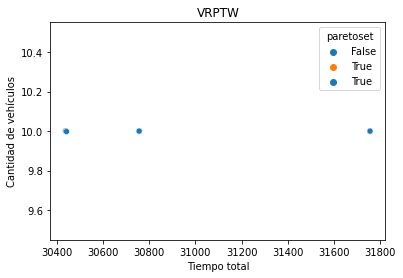

In [13]:
instancia = procesar_instancia("datos/original/vrptw_c101.txt")
individuo_tamanho = 100
poblacion_tamanho = 100
c_pbb = 0.8
m_pbb = 0.3
generaciones = 100

pob = []
par = []
for x in range(poblacion_tamanho):
    pob.append(inicializarIndividuo(instancia['num'], instancia['num']-1))

pob, par = spea(pob, par, instancia)
graficar(pob)
graficar(par)